In [1]:
import torch
import os
import numpy as np
import scipy.ndimage
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim, nn
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from PIL import Image

from matplotlib import pyplot as plt

## Setting up the model

First, we download a pre-trained vgg19 model (as recommended in the paper).

In [2]:
vgg = models.vgg19(pretrained=True)

Load the model onto your GPU (if you have one) and "freeze" it, preventing any additional gradient updates from occurring to the already trained model. 

**Note:** I'm freezing each set of parameters individually *after* loading the model into my GPU. This is because the process of loading into the GPU destroys the old parameter tensors and creates new ones on the GPU (so freezing beforehand would have no effect).

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg = vgg.to(device)
for param in vgg.features.parameters(): # stop training the net
    param.requires_grad = False

Confirm that the network really is loaded onto the GPU.

In [4]:
next(vgg.parameters()).is_cuda # Should be `True` if you have a GPU

True

Optionally, we can also replace all the max pool layers in our vgg network with average pool layers as suggested in the paper. Personally I found that this made gradient updates a bit trickier, but it did give nicer results once I got it working.

In [5]:
vgg_layers = list(vgg.children())[0]

for i in range(len(vgg_layers)):
    if (vgg_layers[i].__class__.__name__ == "MaxPool2d"):
        vgg_layers[i] = nn.AvgPool2d(2)

Lastly, we'll remove the fully connected layers from our pretained vgg network. We don't need these for texture synthesis, and leaving them in limits us to input images of size 224x224 only.

**Note:** `some_model.children()` returns an iterator containing all of the model's layers. Common practice is to turn this into a list in order to interact with it. With vgg19 what you'll actually get is a list containing two lists. The first of these contains all the layers we need.

In [6]:
useful_layers = list(vgg.children())[0]
vgg = nn.Sequential(useful_layers)
len(list(vgg.children())[0]) # should be 37

37

## Perpairing the example texture

The pre-trained networks from torchvision.models need to be passed inputs in a certain format, so we're going to add a transform to apply those transformations to all the image's we're dealing with. We also define a helper function `image_loader` which takes a relative image path, loads the image into a tensor, applies the relevant transformations and returns it.

`show_image` makes it easier to view images we load using `image_loader`. Pytorch doesn't seem to have any good method for visualizing tensors, so we convert the tensor to a numpy array, transpose it and then plot that using matplotlib.

**Note:** `unsqueeze()` is a pytorch function that adds extra dimensions to tensors. We're using it here because vgg19 only takes mini-batches of images, and we're working with a single image. We use `.unsqueeze()` to add the extra dimension to our image tensor and trick vgg into thinking it's dealing with a small minibatch of images. 

**Note 2:** For classification vgg19 expects input images to be normalized according to imagenet mean values. The commented out line below applies this transform. We're not doing classification though and *should not* add it here. It would cause our sample textures to be optimized to look like the *normalized* version of the example texture (i.e. off color and weird). See `data/samples/stones-normalized` for what happened to me. We can also ignore the usual size constraint of 224x224 since convolutional layers are size-agonstic and we already removed all the fully connected layers.

In [7]:
transform = transforms.Compose([
        transforms.RandomCrop(300),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

def image_loader(image_path):
    """load image, returns cuda tensor"""
    image = Image.open(image_path)
    image = transform(image).float()
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

def show_image(image_tensor):
    np_image = image_tensor.squeeze().cpu().detach().numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

Now we actually load in the image (and also plot it out).

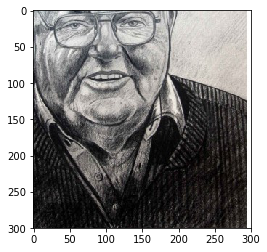

In [8]:
img_path = "data/examples/"
img_name = "pencil-2.jpg" # we use this variable later
full_path = img_path + img_name

example_texture = image_loader(full_path)
show_image(example_texture)

## Extracting Layer activations

The guys in the paper defined the texture profile of the example texture as the **gram matrices** of the feature maps of some of the convolutional or pooling layers in vgg19 after feeding in that example texture. In order to get at these feature maps we're going to use pytorch's hook feature. 

### Hooks

Basically hooks are classes with `.hook_fn`, `.__init__` and `close` methods. `__init__` should take a layer from a module and register the hook's `hook_fn` method on that layer. Whenever the layer is run from then on, `hook_fn` for that hook instance will be called, being passed in the model holding the layer, the layer's input and the layer's output in that order. Let's ignore `close()` for now.

In this case all we want to do is save the output of each layer, so we create a simple `hook_fn` that just saves the layer's output tensor on the hook instance for later use when called.

In [9]:
class SaveFeatures():
    features=None
    def __init__(self, layer): 
        self.hook = layer.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        self.features = output
    def close(self): 
        self.hook.remove()

The guys from the paper found that we don't need input from every single layer. One from each **scale** of the network (a new scale occurs when the input is down-sampled, i.e. pooling layers) seems to be enough. We register a hook instance on a convolutional or pooling layer from each scale (there are 5 scales in vgg).

In [10]:
layer_feature_maps = []

all_layers = list(vgg.children())[0]

for index in [2, 5, 18, 25, 36]:
    layer = all_layers[index]
    layer_name = layer.__class__.__name__
    if layer_name == "Conv2d"  or layer_name == 'MaxPool2d' or layer_name == 'AvgPool2d':
        layer_feature_maps.append(SaveFeatures(layer))

print(len(layer_feature_maps)) # should be 5

5


Now we just run our network with all those conv and pooling layers already hooked, and the `.features` attributes of all our hook instances will automatically be populated with the feature maps of all those layers (as per `hook_fn`). 

In [11]:
print(type(layer_feature_maps[2].features) == type(None)) # should be True the first time you run this
vgg(example_texture)
print(layer_feature_maps[2].features[0][0][0]) # should be a tensor with random numbers in

True
tensor([0.8633, 0.9462, 0.4894, 1.0545, 0.9150, 1.1850, 0.7244, 1.0679, 1.1947,
        0.9279, 1.2096, 0.6581, 0.3704, 0.9826, 1.1539, 0.5774, 0.1644, 0.0000,
        0.0000, 0.0000, 0.2814, 0.0000, 0.3968, 0.3519, 1.0501, 0.6145, 0.2460,
        0.1061, 0.1382, 0.4696, 0.3208, 0.1479, 0.2054, 0.4082, 0.1227, 0.1632,
        0.5197], device='cuda:0')


So now we have all the feature maps we need, but for texture synthesis we want to make a gram matrix for each layer's feature maps. Let's make a helper function that takes all the feature maps from a layer and returns a gram matrix. I copy-pasted this myself from somewhere random.

In [12]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d) # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Now we have this function, let's use it to create a list of gram matrices, one for each layer we're interested in. This list represents all the summary statistics we will need from the example input. The values in this tensor will probably be tiny, or actually 0.

In [13]:
example_stats = [gram_matrix(layer.features) for layer in layer_feature_maps]
print(len(example_stats)) # should be 5
print(example_stats[0]) # should be a tensor. It will probably have very small values.

5
tensor([[0.0013, 0.0000, 0.0018,  ..., 0.0008, 0.0004, 0.0004],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0018, 0.0000, 0.0111,  ..., 0.0047, 0.0009, 0.0026],
        ...,
        [0.0008, 0.0000, 0.0047,  ..., 0.0023, 0.0004, 0.0011],
        [0.0004, 0.0000, 0.0009,  ..., 0.0004, 0.0006, 0.0006],
        [0.0004, 0.0000, 0.0026,  ..., 0.0011, 0.0006, 0.0031]],
       device='cuda:0')


## Computing Loss

Next we need a way of generating a loss from the example summary statistics (above), and some sample summary statistics (which we will eventually generate by passing the sample texture through our vgg network in exactly the same way). The paper recommends calculating the **mean squared error** loss between the two sets of gram matrices.

I had a lot of trouble with this. The losses were always tiny (probably because, as above, the gram matrices I calculated from the feature maps tended to hold super small values), and often resulted in outright 0 gradients. The hacky-as-balls solution I came up with was to literally just scale the loss by some factor before returning. Gross I know.

The paper also recommends using LBFGS to perform gradient updates. `torch.optim` provides a convenience [method](https://pytorch.org/docs/stable/optim.html) for this which you should probably look up. The main takeaway is: if you're using `torch.optim.LBFGS()` as your optimizer, you can't just call `optimizer.step()` like normal. Instead, you need to pass in a special `closure()` function that calculates and returns your loss. Because we can't pass any arguments to the `closure()` function directly, we're going to create a class (`GradientStepper`) around this `closure()` function and use attribute variables on that class as parameters to our `closure()`. 

We'll also add our loss function to this class for conveniance.

In [14]:
class GradientStepper():
    def __init__(self, optimizer, model, sample_texture, layer_feature_maps, scale):
        self.optimizer = optimizer
        self.sample_texture = sample_texture
        self.model = model
        self.layer_feature_maps = layer_feature_maps
        self.scale = scale

    def loss_fn(self, stats, target_stats):
        loss = 0
        for i in range(len(target_stats)):
            loss += torch.mean((stats[i] - target_stats[i]).pow(2)) # mean squared error

        print("scale: {}".format(self.scale))
        return loss * self.scale
    
    def closure(self):
        self.optimizer.zero_grad() # Please read up on this if you don't know what it does. 

        self.model(self.sample_texture)
        sample_stats = [gram_matrix(layer.features) for layer in self.layer_feature_maps]

        loss = self.loss_fn(sample_stats, example_stats)
        loss.backward()

        print("loss: {}".format(loss))

        return loss


## Create the Sample Texture

Nearly there. Now we need to create a random image that will eventually become out sample texture. We're going to pass this texture through our vgg network and keep performing gradient descent on it against the above loss function until its summary statistics more or less match the example texture.

We use numpy to create the random image here because numpy is generally better at operating on matrices. In particular we want to smoothen the image because real life images have a natural smoothness to them.


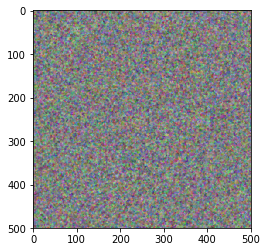

In [15]:
def random_image(blur=6):
    # create random noise numpy array
    np_sample = np.random.rand(500, 500, 3)

    # smooth it out (try commenting out this line and see the difference)
    np_sample = scipy.ndimage.filters.median_filter(np_sample, [blur, blur,1]) 

    # finally convert to a tensor with autograd enabled (since we're 
    # going to be performing gradient updates on this image)
    sample = torch.from_numpy(np_sample).float().permute(2, 0, 1).unsqueeze(0).to(device) 
    sample.requires_grad = True
    
    return sample

show_image(random_image(5))

## Generate the Sample Texture

And here we are. Basically all we do now is perform an arbitrary number of gradient updates on the random sample texture. Once that's done it should look a bit like the example texture (hopefully). To make this clean and reusable, we're going to pack this process into a class called `Synthesizer`, which will take in a bunch of hyperparameters and also save the generated textures as `.jpg`'s for viewing later.

First though, we're going to define some conveniance functions.

In [16]:
def make_optimizer(name, sample_texture, lr):
    if name == "LBFGS":
        return optim.LBFGS([sample_texture], lr=0.1)
    if name == "Adam":
        return optim.Adam([sample_texture], lr=0.1) 
    
    raise ValueError('Name was not a valid optimizer identifier')

### Viewing Images

Rather than displaying the generated images here in the notebook I'm saving them to directories in this workspace. This way we can examine them at them at our leisure later. In particular I want to save a bunch of images throughout the generation process so I can observe how it's going. I'm going to give each image an "identifier", which is basically just a string representation of the hyperparameters used to generate it.


In [17]:
def identifier(params):
    id = ""
    for key in params:
        if key not in ["layer_feature_maps", "model", "iterations", "id"]:
            if key == "name":
                id += params[key].replace(".jpg", "") + "-"
            else:
                id += "{}{}-".format(key, params[key])
        
    return id[:-1]

### Synthesizer

The only important method is `synthesize`, the rest of it is just there to save the sample textures to the right directories. Basically this method takes a bunch of hyperparameters, generates a (quasi) random image, and performs gradient updates on it for a given number of iterations using the `GradientStepper` class we defined earlier.

In [18]:
class Synthesizer():
    
    sample_directory = "data/samples"
    
    def __init__(self, params):
        self.save_mode = params["save_mode"]
               
    def prepair_save_directory(self, params):
        self.identifier = params["id"]
        
        if self.save_mode == "final":
            self.dir_path = Synthesizer.sample_directory + "/lol"
            self.save_at = params["iterations"]
            
        elif self.save_mode == "throughout":
            self.dir_path = Synthesizer.sample_directory + "/" + self.identifier
            self.save_at = 1
        
        if not os.path.exists(self.dir_path):
            os.makedirs(self.dir_path)
    
    def save_path(self):
        if self.save_mode == "final":
            file_name = self.identifier
        elif self.save_mode == "throughout":
            file_name = self.save_at
        
        return "{}/{}.jpg".format(self.dir_path , file_name)
    
    def synthesize(self, params):
        sample_texture = random_image(params["blur"])
        optimizer = make_optimizer(params["optimizer"], sample_texture, params["lr"]) 
        stepper = GradientStepper(optimizer, params["model"], sample_texture, params["layer_feature_maps"], params["scale"])
        
        self.prepair_save_directory(params)

        for i in range (params["iterations"]):
            if sample_texture.grad is not None:
                print(sample_texture.grad[0][0][0][:4])

            optimizer.step(stepper.closure)

            # occationally save an image so see how generation is going
            if (i + 1) == self.save_at:
                save_image(sample_texture, self.save_path())
                self.save_at *= 2

                if params["scale_decay"] > 0:
                    stepper.scale -= (stepper.scale / params["scale_decay"])
        
        return sample_texture

### Execution

Feel free to fiddle around with hyperparameters here, but I did a fair bit of fiddling myself, and to be honest  the only thing that seemed to make any real difference was the scale, which just needed to remain > 10,000.

In [20]:
params = {
    "name": img_name,
    "size": "500x500",
    "layers": 5,
    "iterations": 128,
    "blur": 5,
    "scale_decay": 0, # 0 means no scale decay
    "scale": 100000,
    "model": vgg,
    "layer_feature_maps": layer_feature_maps,
    "optimizer": "LBFGS",
    "lr": 0.1,
}

meta_params = {
    "save_mode": "throughout" 
    # determine whether to save just the final image, or save at intervals while generating
}

syn = Synthesizer(meta_params)

for s in [100000]:
    for sd in [0]:
        for blur in [5]:
            params["scale_decay"] = sd
            params["scale"] = s
            params["blur"] = blur
            params["id"] = identifier(params) 

            print(params["id"])

            syn.synthesize(params)

pencil-2-size500x500-layers5-blur5-scale_decay0-scale100000-optimizerLBFGS-lr0.1
scale: 100000
loss: 0.15711520612239838
scale: 100000
loss: 0.15711428225040436
scale: 100000
loss: 0.15711021423339844
scale: 100000
loss: 0.12937889993190765
scale: 100000
loss: 0.11125325411558151
scale: 100000
loss: 0.08632843941450119
scale: 100000
loss: 0.06863359361886978
scale: 100000
loss: 0.05721514672040939
scale: 100000
loss: 0.04828199744224548
scale: 100000
loss: 0.04071929305791855
scale: 100000
loss: 0.03435082361102104
scale: 100000
loss: 0.029071949422359467
scale: 100000
loss: 0.02470245584845543
scale: 100000
loss: 0.02115023508667946
scale: 100000
loss: 0.018206477165222168
scale: 100000
loss: 0.015787340700626373
scale: 100000
loss: 0.01377083733677864
scale: 100000
loss: 0.012094481848180294
scale: 100000
loss: 0.010702159255743027
scale: 100000
loss: 0.00955868512392044
tensor([1.7787e-07, 1.2042e-07, 1.7575e-07, 1.2761e-07], device='cuda:0')
scale: 100000
loss: 0.008619789965450764

scale: 100000
loss: 0.00024161752662621439
scale: 100000
loss: 0.00023997609969228506
scale: 100000
loss: 0.0002383100363658741
scale: 100000
loss: 0.00023675845295656472
scale: 100000
loss: 0.00023514074564445764
scale: 100000
loss: 0.00023366317327599972
scale: 100000
loss: 0.00023207248887047172
scale: 100000
loss: 0.0002305415691807866
scale: 100000
loss: 0.00022903623175807297
scale: 100000
loss: 0.00022759319108445197
scale: 100000
loss: 0.00022615886700805277
scale: 100000
loss: 0.00022466482187155634
scale: 100000
loss: 0.00022315606474876404
scale: 100000
loss: 0.00022162118693813682
scale: 100000
loss: 0.00022017740411683917
scale: 100000
loss: 0.00021880546410102397
scale: 100000
loss: 0.00021737549104727805
scale: 100000
loss: 0.0002160220901714638
scale: 100000
loss: 0.0002145984908565879
scale: 100000
loss: 0.0002132990484824404
tensor([-1.5220e-08, -3.7071e-09,  6.9542e-09,  6.1667e-09], device='cuda:0')
scale: 100000
loss: 0.00021188198297750205
scale: 100000
loss: 0.00

scale: 100000
loss: 0.00011200845619896427
scale: 100000
loss: 0.00011167438060510904
tensor([-3.5570e-09,  2.3900e-09,  7.3040e-09,  2.6093e-09], device='cuda:0')
scale: 100000
loss: 0.00011134015949210152
scale: 100000
loss: 0.0001109932127292268
scale: 100000
loss: 0.00011065429862355813
scale: 100000
loss: 0.00011029039887944236
scale: 100000
loss: 0.00010995484626619145
scale: 100000
loss: 0.00010964541434077546
scale: 100000
loss: 0.00010929977725027129
scale: 100000
loss: 0.0001089732613763772
scale: 100000
loss: 0.0001086292031686753
scale: 100000
loss: 0.00010829974780790508
scale: 100000
loss: 0.00010797479626489803
scale: 100000
loss: 0.00010765470506157726
scale: 100000
loss: 0.00010734689567470923
scale: 100000
loss: 0.0001070465732482262
scale: 100000
loss: 0.00010675277007976547
scale: 100000
loss: 0.00010645090515026823
scale: 100000
loss: 0.00010614989150781184
scale: 100000
loss: 0.00010586402640910819
scale: 100000
loss: 0.00010558186477283016
scale: 100000
loss: 0.0

scale: 100000
loss: 7.41554977139458e-05
scale: 100000
loss: 7.403406198136508e-05
scale: 100000
loss: 7.389706297544762e-05
tensor([3.8790e-09, 4.7431e-09, 3.7353e-09, 4.5933e-09], device='cuda:0')
scale: 100000
loss: 7.375374116236344e-05
scale: 100000
loss: 7.361451571341604e-05
scale: 100000
loss: 7.347223436227068e-05
scale: 100000
loss: 7.334468682529405e-05
scale: 100000
loss: 7.321085286093876e-05
scale: 100000
loss: 7.308280328288674e-05
scale: 100000
loss: 7.294741226360202e-05
scale: 100000
loss: 7.281175930984318e-05
scale: 100000
loss: 7.26785947335884e-05
scale: 100000
loss: 7.25470672477968e-05
scale: 100000
loss: 7.242370338644832e-05
scale: 100000
loss: 7.229265611385927e-05
scale: 100000
loss: 7.216302765300497e-05
scale: 100000
loss: 7.202921551652253e-05
scale: 100000
loss: 7.190422911662608e-05
scale: 100000
loss: 7.179105887189507e-05
scale: 100000
loss: 7.166925934143364e-05
scale: 100000
loss: 7.154341437853873e-05
scale: 100000
loss: 7.141929381759837e-05
scale

scale: 100000
loss: 5.663119372911751e-05
scale: 100000
loss: 5.6562730605946854e-05
scale: 100000
loss: 5.6494191085221246e-05
scale: 100000
loss: 5.642401083605364e-05
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 100000
loss: 5.635818888549693e-05
scale: 100000
loss: 5.629019869957119e-05
scale: 100000
loss: 5.62227432965301e-05
scale: 100000
loss: 5.6154847698053345e-05
scale: 100000
loss: 5.6088101700879633e-05
scale: 100000
loss: 5.6019598559942096e-05
scale: 100000
loss: 5.59476284252014e-05
scale: 100000
loss: 5.5873257224448025e-05
scale: 100000
loss: 5.580854485742748e-05
scale: 100000
loss: 5.5744403653079644e-05
scale: 100000
loss: 5.567484913626686e-05
scale: 100000
loss: 5.560589852393605e-05
scale: 100000
loss: 5.553939627134241e-05
scale: 100000
loss: 5.547191540244967e-05
scale: 100000
loss: 5.5401393183274195e-05
scale: 100000
loss: 5.5334330681944266e-05
scale: 100000
loss: 5.526968743652105e-05
scale: 100000
loss: 5.5207026889547706e-05
scale:

scale: 100000
loss: 4.6371813368750736e-05
scale: 100000
loss: 4.632568379747681e-05
scale: 100000
loss: 4.627963062375784e-05
scale: 100000
loss: 4.623119093594141e-05
tensor([-1.1725e-09, -4.9545e-10,  6.4123e-10,  1.8384e-10], device='cuda:0')
scale: 100000
loss: 4.618662933353335e-05
scale: 100000
loss: 4.61436684418004e-05
scale: 100000
loss: 4.6097480662865564e-05
scale: 100000
loss: 4.605279173119925e-05
scale: 100000
loss: 4.600699685397558e-05
scale: 100000
loss: 4.5963046432007104e-05
scale: 100000
loss: 4.592038385453634e-05
scale: 100000
loss: 4.587700459524058e-05
scale: 100000
loss: 4.583562622428872e-05
scale: 100000
loss: 4.579217784339562e-05
scale: 100000
loss: 4.574804552248679e-05
scale: 100000
loss: 4.5706048695137724e-05
scale: 100000
loss: 4.566405914374627e-05
scale: 100000
loss: 4.5622087782248855e-05
scale: 100000
loss: 4.557972351904027e-05
scale: 100000
loss: 4.553738472168334e-05
scale: 100000
loss: 4.5494631194742396e-05
scale: 100000
loss: 4.5450749894371

scale: 100000
loss: 3.9844639104558155e-05
scale: 100000
loss: 3.981422196375206e-05
scale: 100000
loss: 3.978639142587781e-05
scale: 100000
loss: 3.97581206925679e-05
scale: 100000
loss: 3.9726754039293155e-05
tensor([-8.8128e-11,  1.1289e-09,  1.7532e-10,  1.0504e-09], device='cuda:0')
scale: 100000
loss: 3.969560202676803e-05
scale: 100000
loss: 3.966427902923897e-05
scale: 100000
loss: 3.9632497646380216e-05
scale: 100000
loss: 3.9600712625542656e-05
scale: 100000
loss: 3.956891305278987e-05
scale: 100000
loss: 3.953884151997045e-05
scale: 100000
loss: 3.951078178943135e-05
scale: 100000
loss: 3.947994264308363e-05
scale: 100000
loss: 3.9449292671633884e-05
scale: 100000
loss: 3.941911199945025e-05
scale: 100000
loss: 3.939119778806344e-05
scale: 100000
loss: 3.9364706026390195e-05
scale: 100000
loss: 3.933594416594133e-05
scale: 100000
loss: 3.9307702536461875e-05
scale: 100000
loss: 3.9277969335671514e-05
scale: 100000
loss: 3.925074270227924e-05
scale: 100000
loss: 3.92228757846

scale: 100000
loss: 3.532682603690773e-05
scale: 100000
loss: 3.53044415533077e-05
scale: 100000
loss: 3.528188244672492e-05
scale: 100000
loss: 3.526069485815242e-05
scale: 100000
loss: 3.5240198485553265e-05
scale: 100000
loss: 3.52166716766078e-05
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 100000
loss: 3.519426900311373e-05
scale: 100000
loss: 3.5171698982594535e-05
scale: 100000
loss: 3.5148405004292727e-05
scale: 100000
loss: 3.512482362566516e-05
scale: 100000
loss: 3.510275564622134e-05
scale: 100000
loss: 3.508101144689135e-05
scale: 100000
loss: 3.50592345057521e-05
scale: 100000
loss: 3.50376867572777e-05
scale: 100000
loss: 3.501600804156624e-05
scale: 100000
loss: 3.499417289276607e-05
scale: 100000
loss: 3.4972017601830885e-05
scale: 100000
loss: 3.495015698717907e-05
scale: 100000
loss: 3.492885298328474e-05
scale: 100000
loss: 3.490841118036769e-05
scale: 100000
loss: 3.488865331746638e-05
scale: 100000
loss: 3.486842251732014e-05
scale: 100000


scale: 100000
loss: 3.2003677915781736e-05
scale: 100000
loss: 3.1987907277652994e-05
scale: 100000
loss: 3.197217301931232e-05
scale: 100000
loss: 3.19562605000101e-05
scale: 100000
loss: 3.194083910784684e-05
scale: 100000
loss: 3.192494477843866e-05
scale: 100000
loss: 3.190867573721334e-05
tensor([-1.3204e-09, -5.3745e-10,  6.0147e-11,  3.0894e-10], device='cuda:0')
scale: 100000
loss: 3.189315611962229e-05
scale: 100000
loss: 3.1878338631941006e-05
scale: 100000
loss: 3.186297544743866e-05
scale: 100000
loss: 3.184693559887819e-05
scale: 100000
loss: 3.183044827892445e-05
scale: 100000
loss: 3.1815132388146594e-05
scale: 100000
loss: 3.179989289492369e-05
scale: 100000
loss: 3.1783871236257255e-05
scale: 100000
loss: 3.176803147653118e-05
scale: 100000
loss: 3.1752122595207766e-05
scale: 100000
loss: 3.173641744069755e-05
scale: 100000
loss: 3.172085416736081e-05
scale: 100000
loss: 3.170526179019362e-05
scale: 100000
loss: 3.1689316529082134e-05
scale: 100000
loss: 3.167455724906

scale: 100000
loss: 2.945568303402979e-05
scale: 100000
loss: 2.9443481253110804e-05
scale: 100000
loss: 2.943098843388725e-05
scale: 100000
loss: 2.9417982659651898e-05
scale: 100000
loss: 2.940502599813044e-05
scale: 100000
loss: 2.9392227588687092e-05
scale: 100000
loss: 2.937978206318803e-05
scale: 100000
loss: 2.9366759918048047e-05
scale: 100000
loss: 2.9354130674619228e-05
tensor([ 1.3150e-09,  5.1446e-10, -3.8392e-10,  4.2729e-10], device='cuda:0')
scale: 100000
loss: 2.9341232220758684e-05
scale: 100000
loss: 2.9328368327696808e-05
scale: 100000
loss: 2.931571361841634e-05
scale: 100000
loss: 2.93029206659412e-05
scale: 100000
loss: 2.9289196390891448e-05
scale: 100000
loss: 2.92754230031278e-05
scale: 100000
loss: 2.9262997486512177e-05
scale: 100000
loss: 2.925009721366223e-05
scale: 100000
loss: 2.9237495255074464e-05
scale: 100000
loss: 2.922413477790542e-05
scale: 100000
loss: 2.921132545452565e-05
scale: 100000
loss: 2.9198416086728685e-05
scale: 100000
loss: 2.918542304

scale: 100000
loss: 2.742756078077946e-05
scale: 100000
loss: 2.741734351729974e-05
scale: 100000
loss: 2.7407342713559046e-05
scale: 100000
loss: 2.7396177756600082e-05
scale: 100000
loss: 2.7385463909013197e-05
scale: 100000
loss: 2.737511385930702e-05
scale: 100000
loss: 2.7364758352632634e-05
scale: 100000
loss: 2.7354642952559516e-05
scale: 100000
loss: 2.7343219699105248e-05
scale: 100000
loss: 2.7332618628861383e-05
scale: 100000
loss: 2.7322519599692896e-05
scale: 100000
loss: 2.731149834289681e-05
tensor([ 1.2807e-09, -1.1184e-09, -1.2232e-10, -1.6040e-09], device='cuda:0')
scale: 100000
loss: 2.7300655347062275e-05
scale: 100000
loss: 2.728931031015236e-05
scale: 100000
loss: 2.7279023925075307e-05
scale: 100000
loss: 2.7268079065834172e-05
scale: 100000
loss: 2.725731064856518e-05
scale: 100000
loss: 2.724688056332525e-05
scale: 100000
loss: 2.7237378162681125e-05
scale: 100000
loss: 2.7227442842558958e-05
scale: 100000
loss: 2.7216992748435587e-05
scale: 100000
loss: 2.7207

scale: 100000
loss: 2.5692306735436432e-05
scale: 100000
loss: 2.5682949853944592e-05
scale: 100000
loss: 2.5674209609860554e-05
scale: 100000
loss: 2.5665331122581847e-05
scale: 100000
loss: 2.5656025172793306e-05
scale: 100000
loss: 2.5646400899859145e-05
scale: 100000
loss: 2.5636798454797827e-05
scale: 100000
loss: 2.5627989089116454e-05
scale: 100000
loss: 2.5618759536882862e-05
scale: 100000
loss: 2.560976099630352e-05
scale: 100000
loss: 2.5601037123124115e-05
scale: 100000
loss: 2.559202039265074e-05
scale: 100000
loss: 2.5583118258509785e-05
scale: 100000
loss: 2.557392872404307e-05
scale: 100000
loss: 2.556531944719609e-05
scale: 100000
loss: 2.5556253604008816e-05
tensor([ 6.3023e-10, -1.4563e-09, -1.0514e-09, -8.4563e-10], device='cuda:0')
scale: 100000
loss: 2.5547458790242672e-05
scale: 100000
loss: 2.5538201953168027e-05
scale: 100000
loss: 2.5529725462547503e-05
scale: 100000
loss: 2.5521501811454073e-05
scale: 100000
loss: 2.5512950742268004e-05
scale: 100000
loss: 2.5

scale: 100000
loss: 2.4176346414606087e-05
scale: 100000
loss: 2.4168090021703392e-05
scale: 100000
loss: 2.4160040993592702e-05
scale: 100000
loss: 2.415137532807421e-05
scale: 100000
loss: 2.414294795016758e-05
scale: 100000
loss: 2.4134389605023898e-05
scale: 100000
loss: 2.4126262360368855e-05
scale: 100000
loss: 2.4117996872519143e-05
scale: 100000
loss: 2.410901288385503e-05
scale: 100000
loss: 2.4100934751913883e-05
scale: 100000
loss: 2.409245826129336e-05
scale: 100000
loss: 2.408479485893622e-05
scale: 100000
loss: 2.407708416285459e-05
scale: 100000
loss: 2.406937892374117e-05
scale: 100000
loss: 2.4061302610789426e-05
scale: 100000
loss: 2.4053597371676005e-05
scale: 100000
loss: 2.4045826648944058e-05
scale: 100000
loss: 2.4038165065576322e-05
scale: 100000
loss: 2.4030214262893423e-05
scale: 100000
loss: 2.4022190700634383e-05
tensor([ 3.6714e-10,  6.0110e-10,  4.0736e-10, -6.5291e-10], device='cuda:0')
scale: 100000
loss: 2.401424353593029e-05
scale: 100000
loss: 2.40060

scale: 100000
loss: 2.2818905563326553e-05
scale: 100000
loss: 2.2812138922745362e-05
tensor([-2.2670e-10, -6.3841e-10, -1.3495e-09,  7.3618e-10], device='cuda:0')
scale: 100000
loss: 2.280512489960529e-05
scale: 100000
loss: 2.279811269545462e-05
scale: 100000
loss: 2.2791191440774128e-05
scale: 100000
loss: 2.2784017346566543e-05
scale: 100000
loss: 2.2776790501666255e-05
scale: 100000
loss: 2.276952363899909e-05
scale: 100000
loss: 2.2762375010643154e-05
scale: 100000
loss: 2.2755188183509745e-05
scale: 100000
loss: 2.274860889883712e-05
scale: 100000
loss: 2.2742173314327374e-05
scale: 100000
loss: 2.2735364836989902e-05
scale: 100000
loss: 2.2728292606188916e-05
scale: 100000
loss: 2.272103665745817e-05
scale: 100000
loss: 2.2713928046869114e-05
scale: 100000
loss: 2.2706730305799283e-05
scale: 100000
loss: 2.269942342536524e-05
scale: 100000
loss: 2.2692003767588176e-05
scale: 100000
loss: 2.268469143018592e-05
scale: 100000
loss: 2.2677249944536015e-05
scale: 100000
loss: 2.2669

scale: 100000
loss: 2.1599369574687444e-05
scale: 100000
loss: 2.1593335986835882e-05
scale: 100000
loss: 2.158719871658832e-05
scale: 100000
loss: 2.158109964511823e-05
scale: 100000
loss: 2.1574403945123777e-05
tensor([ 1.1231e-10,  3.0293e-10, -2.5490e-11, -6.2729e-10], device='cuda:0')
scale: 100000
loss: 2.1567708245129324e-05
scale: 100000
loss: 2.156104164896533e-05
scale: 100000
loss: 2.1554031263804063e-05
scale: 100000
loss: 2.1547108190134168e-05
scale: 100000
loss: 2.154061985493172e-05
scale: 100000
loss: 2.1533764083869755e-05
scale: 100000
loss: 2.1526710042962804e-05
scale: 100000
loss: 2.1519836082006805e-05
scale: 100000
loss: 2.151326225430239e-05
scale: 100000
loss: 2.1506482880795375e-05
scale: 100000
loss: 2.1499588910955936e-05
scale: 100000
loss: 2.1493216991075315e-05
scale: 100000
loss: 2.1486323021235876e-05
scale: 100000
loss: 2.1479490897036158e-05
scale: 100000
loss: 2.1472800654009916e-05
scale: 100000
loss: 2.1466439648065716e-05
scale: 100000
loss: 2.14